Exploring the output files generated by the Salish Sea Atlantis Model
to try to reeduce PAH build-up in the biopools.

### Test Descriptions & Notes

Test scenarios
1. reduce contam decay timestep to bm -> dt (changed time_step to bm->dt for all contam species decay atContaminants.c line 1077)
1. changed the PAH half_life from being denominated in seconds -> days
1. removed division by time_step atContaminants.c line 1092: bm->contaminantStructure[cIndex]->sp_amount_decayed[sp][cohort] = (cGroupLevel - newValue); (degrate contam in species) [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/fae0e0464112bf59cd496e62a5ff2d44895c1617/notebooks/SSAM-output-biopools.ipynb)
1. removed division by time_step (/dtsz) atContaminants.c line 953: transfer = cGroupLevel * propEaten (contam transfer). [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/0b4862f28e36ef539ce0e7d180a72a7a87ab8e87/notebooks/SSAM-output-biopools.ipynb)
1. change contam_dissolv_coefft 1 in the bio.prm file. [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/3efaad9acdb5929fbf11b8aa737ed40fa30e777a/notebooks/SSAM-output-biopools.ipynb)
1. removed division by time_step (/dtsz) atContaminants.c line 416: amount_decayed = cLevel - newValue (degrade contam in water column) [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/1320cfc3140c669439dbe1ad54ef91d871b4bc3b/notebooks/SSAM-output-biopools.ipynb)
1. Test 6 + removed division by time_step (/dtsz) atContaminants.c line 1100: sp_amount_decayed = cLevel - newValue [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/7459dac1add5bf58396aef32507c89a9c64daa10/notebooks/SSAM-output-biopools.ipynb)
1. Test 4 + Test 6 + removed (* bm->dtsz_stored) from atContaminants.c line 468. Did not add /dtsz in atContaminants.c line 490 because led to -nan flux values. [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/5245e388fe788695751c2b58fbe2055c7e92002c/notebooks/SSAM-output-biopools.ipynb)
1. Test 4 + removed division by time_step atContaminants.c line 1100: sp_amount_decayed [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/093657449acf20da2af9c3f4393fa1aeb57911c8/notebooks/SSAM-output-biopools.ipynb)
1. Test 4 + Test 6 [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/a5bb29598a378f6a70d5000eb0cca481ad7321a9/notebooks/SSAM-output-biopools.ipynb)
1. Test 4 + test 6 repeated with lower bio uptake rates and no zero contam03.nc forcing file [Results](https://github.com/SS-Atlantis/analysis-raisha/blob/ee37bf32732471a5c019b976d1c602f296b85038/notebooks/SSAM-output-biopools.ipynb)
1. Accounting for contam in and out, using [these concentrations](https://github.com/SS-Atlantis/analysis-raisha/blob/5b69b94698c73733f40d842579180321392bd1c8/notebooks/contaminant-dispersal/SSAM-parse-tracks.ipynb) (use_resets = 0 for file 3)
1. same as 12 but use_resets = 1 for file 3
1. atContaminant.c line 470 added division by bm->dtsz_stored to cLevel to make it a rate before subtracting amount_decayed
1. 14 + Added a value of 0.01 to the biology.prm file for dissolv_coefft and removed the interger check in arBiologyXMLParamIO.c line 3779. This affects line 672 in atContaminants.c Gain_Contaminants(), transfer = cGroupLevel * propLost * bm->contaminantStructure[cIndex]->dissolv_coefft / (1 + bm->dtsz_stored); Added the 1+ so that this value is not NaN when bm->dtsz_stored = 0.
1. modified 15 [atContaminants.c] line line 672 transfer = cGroupLevel * propLost * bm->contaminantStructure[cIndex]->dissolv_coefft / (small_num + bm->dtsz_stored); Updated dissolv_coefft to 1 in biology.prm. 


- [comparison of tests 4 & 8](https://github.com/SS-Atlantis/analysis-raisha/blob/d3144b238e7e05e9fe9fcd9ece80a3645e54f30c/notebooks/SSAM-output-biopools.ipynb)
- [tests 10 & 8 identical](https://github.com/SS-Atlantis/analysis-raisha/blob/9ca189d83d4d0ea9bb96ec1d7243cf8138f447ba/notebooks/SSAM-output-biopools.ipynb)

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

### Package and file nports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from PIL import Image
import glob
from IPython.display import Image as img
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
control_name = 'v6693_16c'
test_name = 'v6699_adjusted'
test2_name = 'v6699'
labels = [control_name,test_name,test2_name]
label = [test_name]

In [5]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [6]:
time_c = np.ma.filled(control.variables['t'], np.nan)

In [7]:
test_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test_name + "/outputSalishSea.nc"
test2_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_" + test2_name + "/outputSalishSea.nc"
test = xr.open_dataset(str(test_path), decode_cf=True)
test2= xr.open_dataset(str(test2_path), decode_cf=True)

In [8]:
time = np.ma.filled(test.variables['t'], np.nan)

In [9]:
scenarios = [control, test, test2]
scen = [test]
cont = [control]
#hr = [highres]

### Functions

In [21]:
def plot_pah(scenario, times):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
        volume_tbl = np.ma.filled(scenario.volume, np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)

        ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH')

In [22]:
def plot_individual_pah(scenario, times, pah):
    fig, ax = plt.subplots(figsize = (14,3))
    contam_tbl = np.ma.filled(scenario.variables[pah], np.nan)
    volume_tbl = np.ma.filled(scenario.volume, np.nan)
    contam_mass_tbl = contam_tbl * volume_tbl
    contam_mass_tb = contam_mass_tbl.sum(axis=2)
    contam_mass_t = contam_mass_tb.sum(axis=1)

    ax.plot(times, contam_mass_t[0:times.size])
    ax.legend(pah)
    ax.set_ylabel('mg PAH')

In [23]:
def tissue_mass(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # mgPAH / m3
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan) #m3
            oil_mass_tbl = oil_tbl * volume_tbl
            oil_mass_tb = oil_mass_tbl.sum(axis=2) 
            oil_mass_t = oil_mass_tb.sum(axis=1) 
            ax.plot(time, oil_mass_t[0:time.size],linewidth = 2, alpha=0.5) #semilogy
        
        #plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        plt.ylabel('mg '+str(pah)+' inside '+str(species), fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);
    #print(sp_volume_tbl[1,60,:])
    #print(sp_volume_tbl[1,60,:]+(sp_volume_tbl[3,60,:]==0))

In [24]:
def tissue_mass_log(group, pah, scens, names=labels, time=time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            oil_tbl = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'][:,:,0:6], np.nan)
            oil_per_N_tbl = oil_tbl * (1/(volume_tbl+(volume_tbl==0)))
            oil_per_N_tb = oil_per_N_tbl.sum(axis=2) 
            oil_per_N_t = oil_per_N_tb.sum(axis=1) 
            ax.semilogy(time, oil_per_N_t[0:time.size],linewidth = 2, alpha=0.5)
        
        plt.ylabel('mg '+str(pah)+' / mg N ', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [27]:
def plot_biomass(group, scens, names=labels):
    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2)
            pelagic_oiled = pelagic_oiled.sum(axis=1)
            ax.plot(time, pelagic_oiled[0:time.size], linewidth = 2)
        
        plt.ylabel('mg N m$^{-3}$', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);

In [28]:
def map_tissue_mass(group, pah, scenarios, v_max=None, v_min=None, _cmap=cm.Purples):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(group), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for species in group:
        for scenario in scenarios:
            dVar_s = scenario.variables[group[species] + '_' + pah][:,:,0:6]
            volume = scenario.variables['volume'][:,:,0:6]
            #dVar_s = dVar_s.sum(axis=2)
            dVar_mass = dVar_s * volume
            vpah_tb = dVar_mass.sum(axis=2)
            vpah_b = vpah_tb.sum(axis=0)

            # Add scenario data to Atlantis spatial data
            map_df['pah'] = vpah_b
            map_df.loc[land_boxes, 'pah'] = 0

            ax = fig.add_subplot(gs[0, position])
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=-0.5) 
            ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
                legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
                )
            tit = str(species + '_' + pah)
            ax.set_title(tit)
            map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
            land_df.plot(ax=ax, color='white');
        position=position+1

In [29]:
def map_aggregate_time(variable_name, scens, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.mean(axis=2)
        pah = dVar_s.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(names[scenario.index], fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1

In [30]:
def map_time_mass(variable_name, scens, time, names=labels, v_max=None, v_min=None):
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        var_bl = scenario.variables[variable_name][time,:,0:6]
        vol_bl = scenario.variables['volume'][time,:,0:6]
        var_mass_bl = var_bl * vol_bl
        var_mass_b = var_mass_bl.mean(axis=1)

        # Add scenario data to Atlantis spatial data
        map_df[variable_name] = var_mass_b
        map_df.loc[land_boxes, variable_name] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = variable_name, cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(variable_name, fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
    fig.suptitle(names)

In [31]:
def map_time_depth(variable_name, scens, time, depth, names=labels, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    map_df = map_df.set_index('BOX_ID')
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    depth_range = ['700 m','400 m', '250 m', '100 m', '50 m', 'surface 25 m', 'sediment']
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scens), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario in scens:
        dVar_s = scenario.variables[variable_name][time,:,depth]
        #dVar_s = dVar_s.mean(axis=1)
        #pah_s = dVar_s.mean(axis=1)
        pah_s = dVar_s

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah_s
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title((variable_name + ' - ' + depth_range[depth] + '_' + str(time)), fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1
        map_df['pah'] = 0

### Water Column

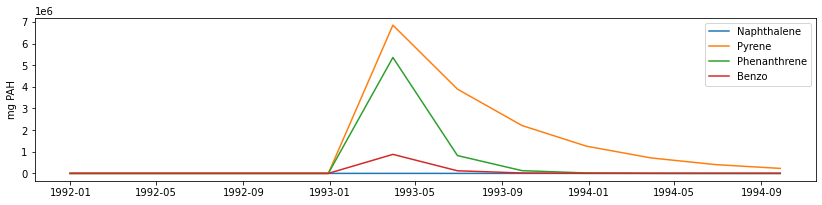

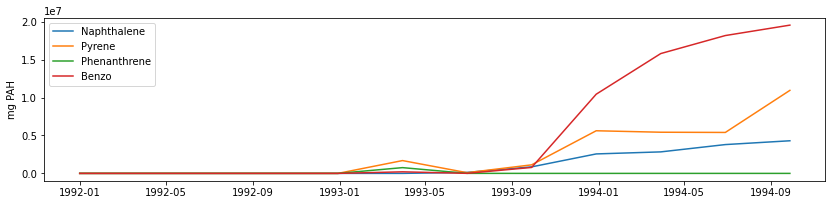

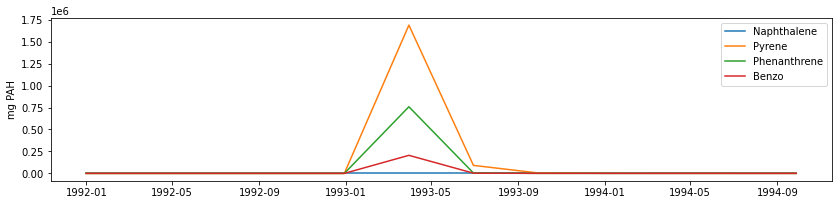

In [22]:
for scenario in scenarios:
    plot_pah(scenario, time)

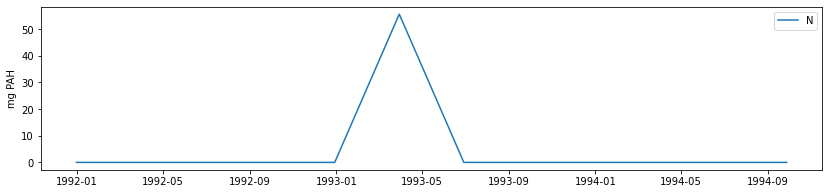

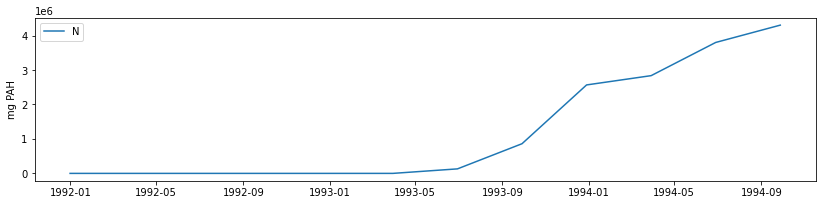

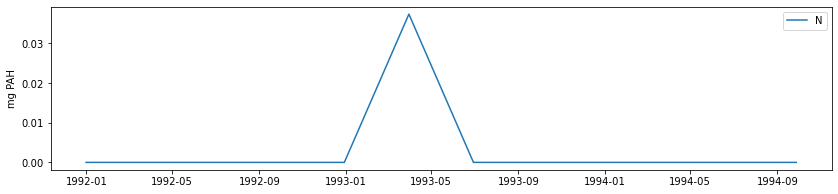

In [26]:
for scenario in scenarios:
    plot_individual_pah(scenario, time, 'Naphthalene')

first time point with contaminants in the water column

In [ ]:
for pah in groups.pahs:
    map_time_mass(pah, scenarios, 5, names=labels, v_max=None, v_min=None) 

In [ ]:
variable_name = 'Naphthalene'
#for depth in range (0, 7):
surface = 5
map_time_depth(variable_name, scenarios, 6, surface, names=labels, v_max=None, v_min=None)

In [ ]:
variable_name = 'Naphthalene'
end = time.size-1
#for depth in range (0, 7):
for pah in groups.pahs:
    map_time_depth(pah, scenarios, end, 5, names=labels, v_max=None, v_min=None)

In [ ]:
for pah in groups.pahs:
    map_time_depth(pah, scenarios, time.size-1, 5, names=labels, v_max=None, v_min=None)

In [ ]:


file_names = []
end = time.size-1
variable_name = 'Naphthalene'
for t in range(0, end):
    map_time_depth(variable_name, scen, t, 5, names=label, v_max=None, v_min=None)
    plot_name = variable_name + '_time_' + str(t).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

# Create the frames
frames = []
imgs = glob.glob("*_time_*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save frames into a loop
anim_name = str(variable_name) + '.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

# Display the figure
with open(anim_name,'rb') as anim:
    display(img(anim.read()))

### Plankton

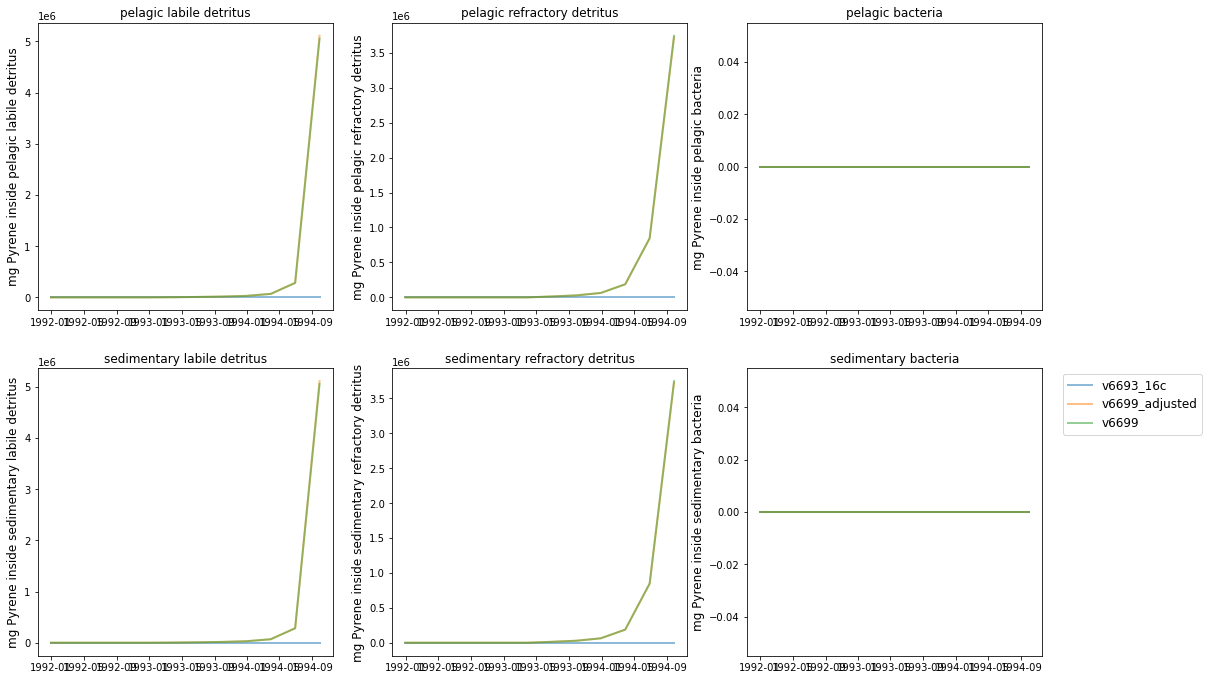

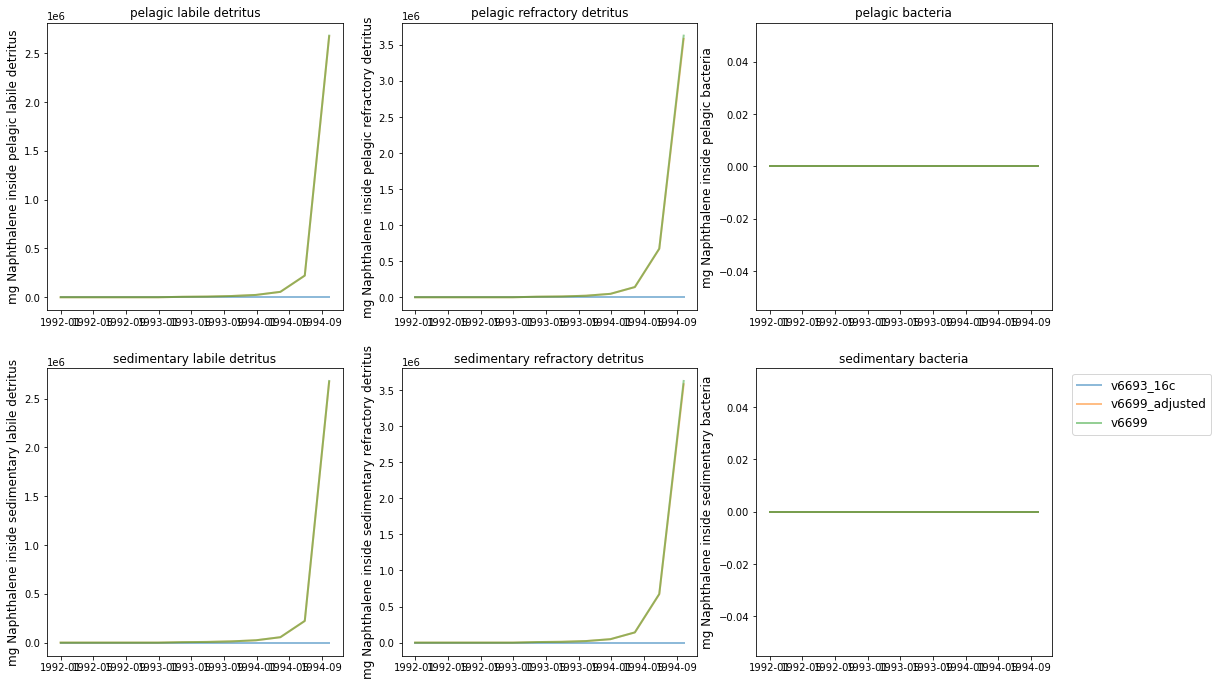

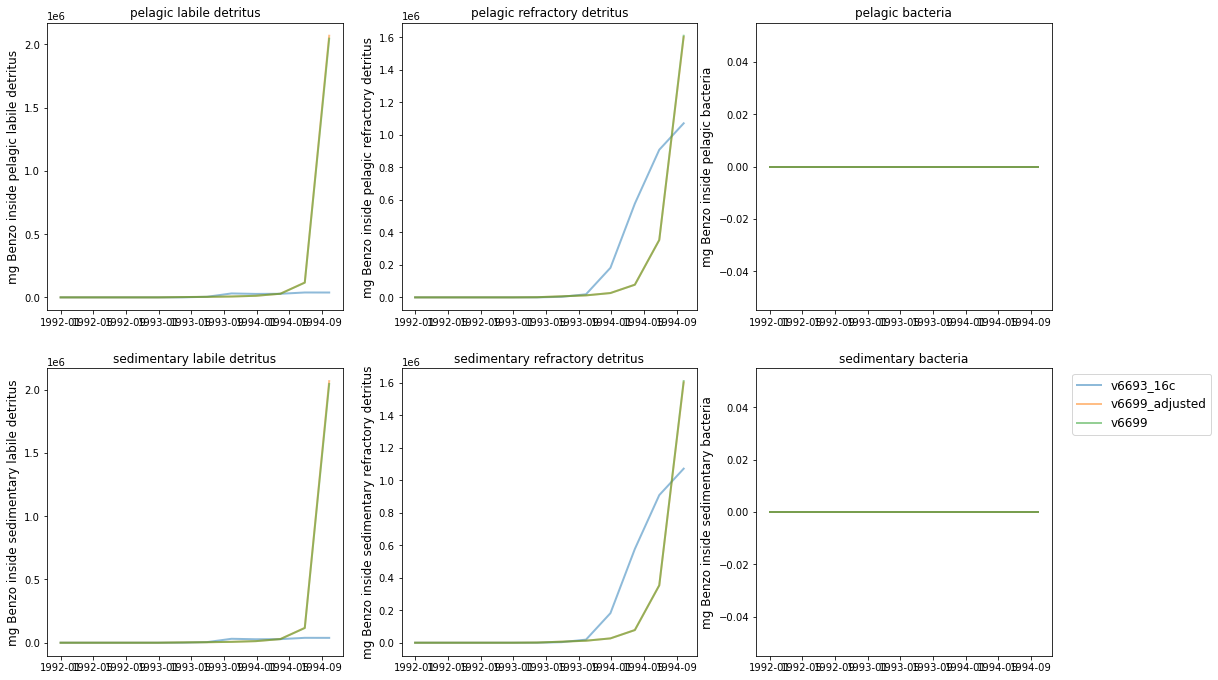

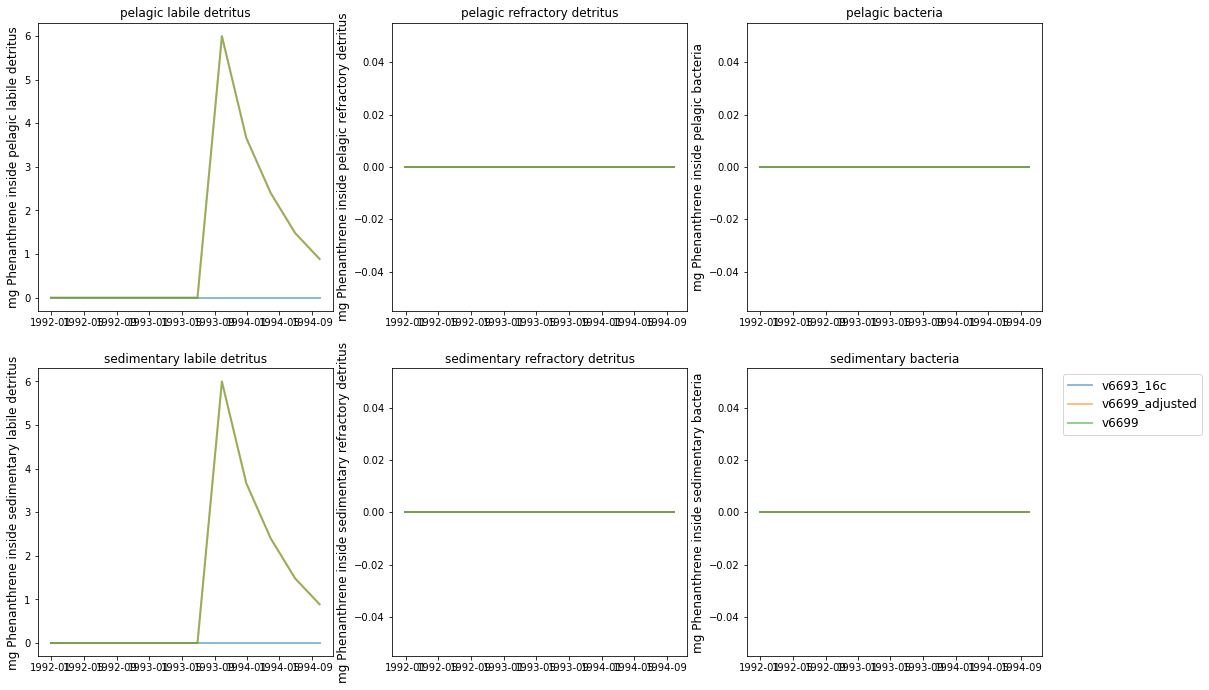

In [32]:
for pah in groups.pahs:
    tissue_mass(groups.bacteria, pah, scenarios, names=labels, time=time)

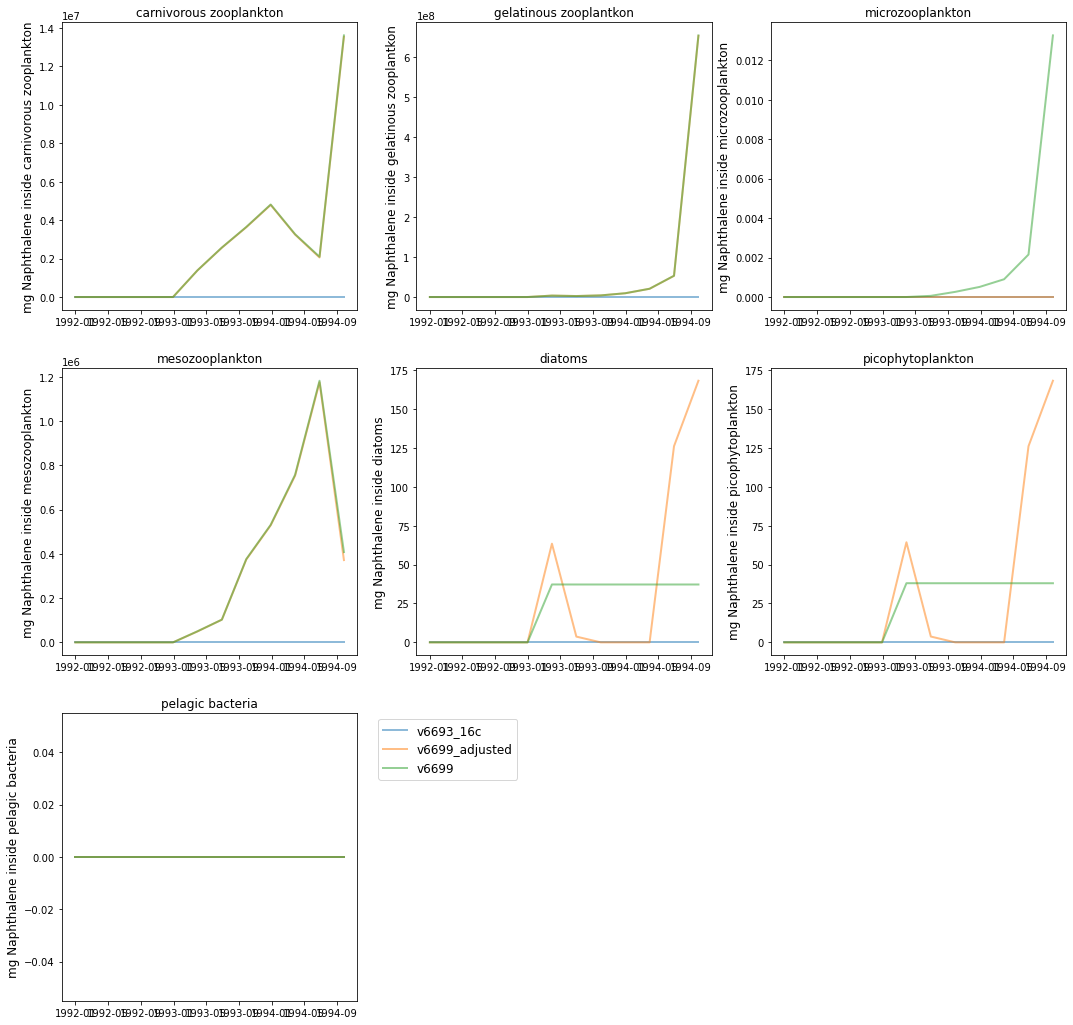

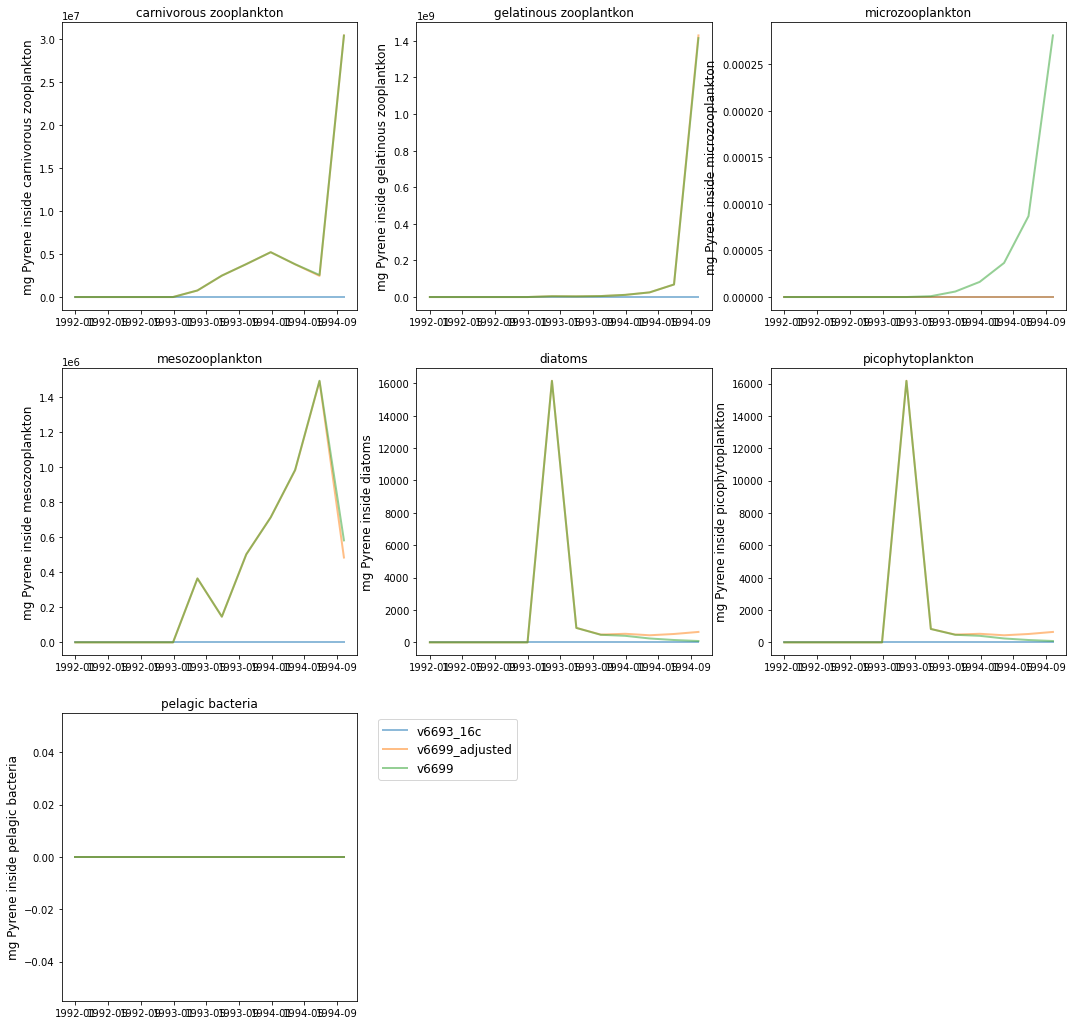

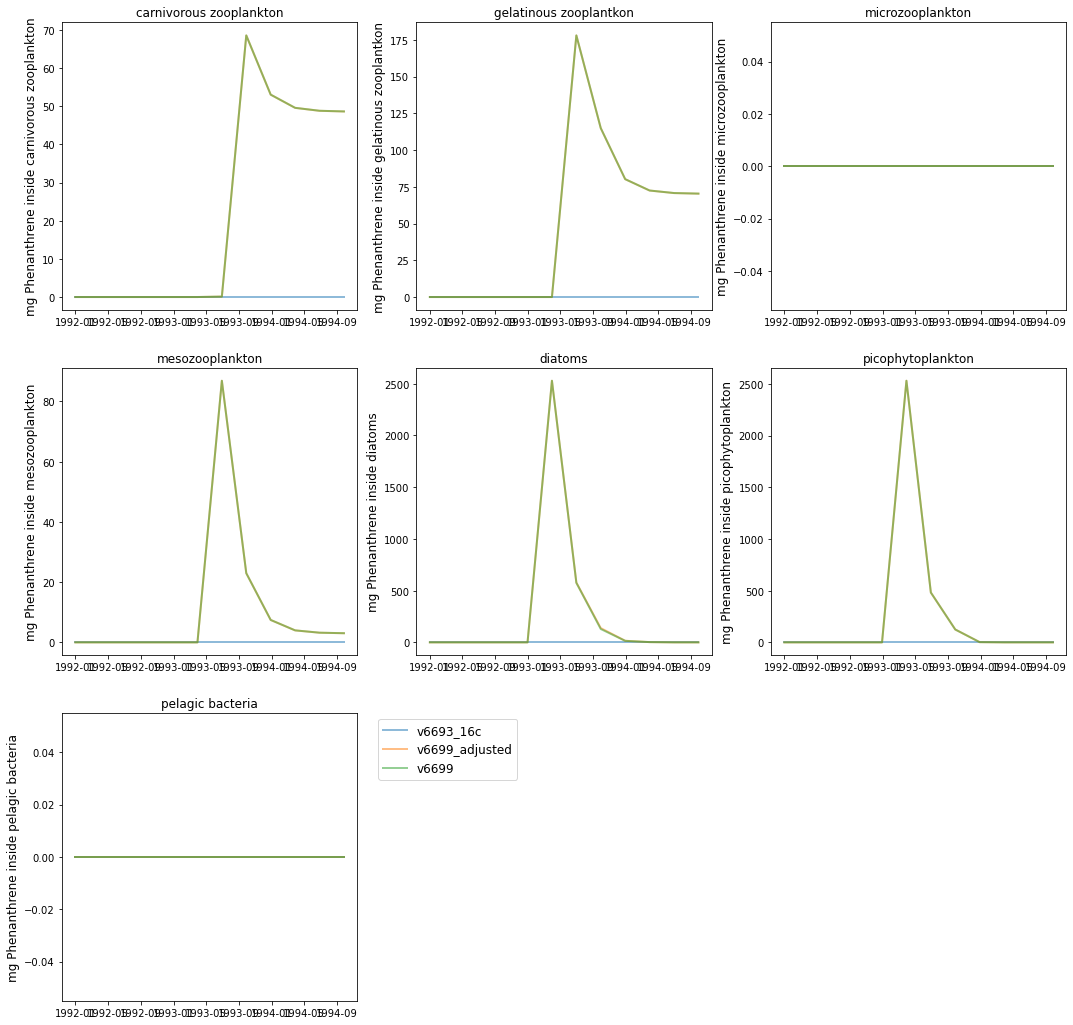

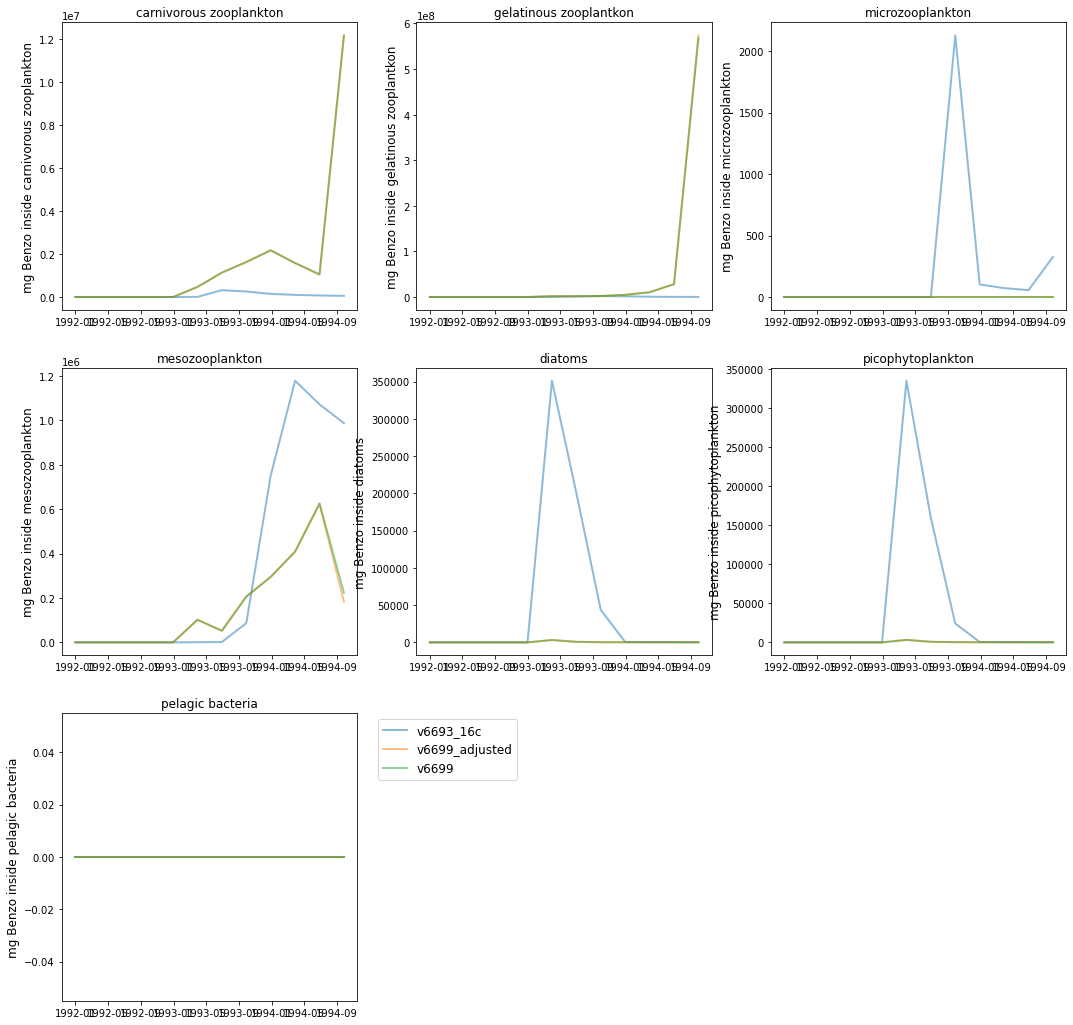

In [30]:
for pah in groups.pahs:
    tissue_mass(groups.plankton, pah, scenarios, names=labels, time=time)

In [62]:
diatom_naph_tbl = np.ma.filled(scenario.variables['Diatom_Naphthalene'][:,:,0:6], np.nan)
diatom_naph_tb = diatom_naph_tbl.sum(axis=2)
diatom_naph_t =  diatom_naph_tb.sum(axis=1)
diatom_naph = diatom_naph_t.sum()
diatom_naph

0.0

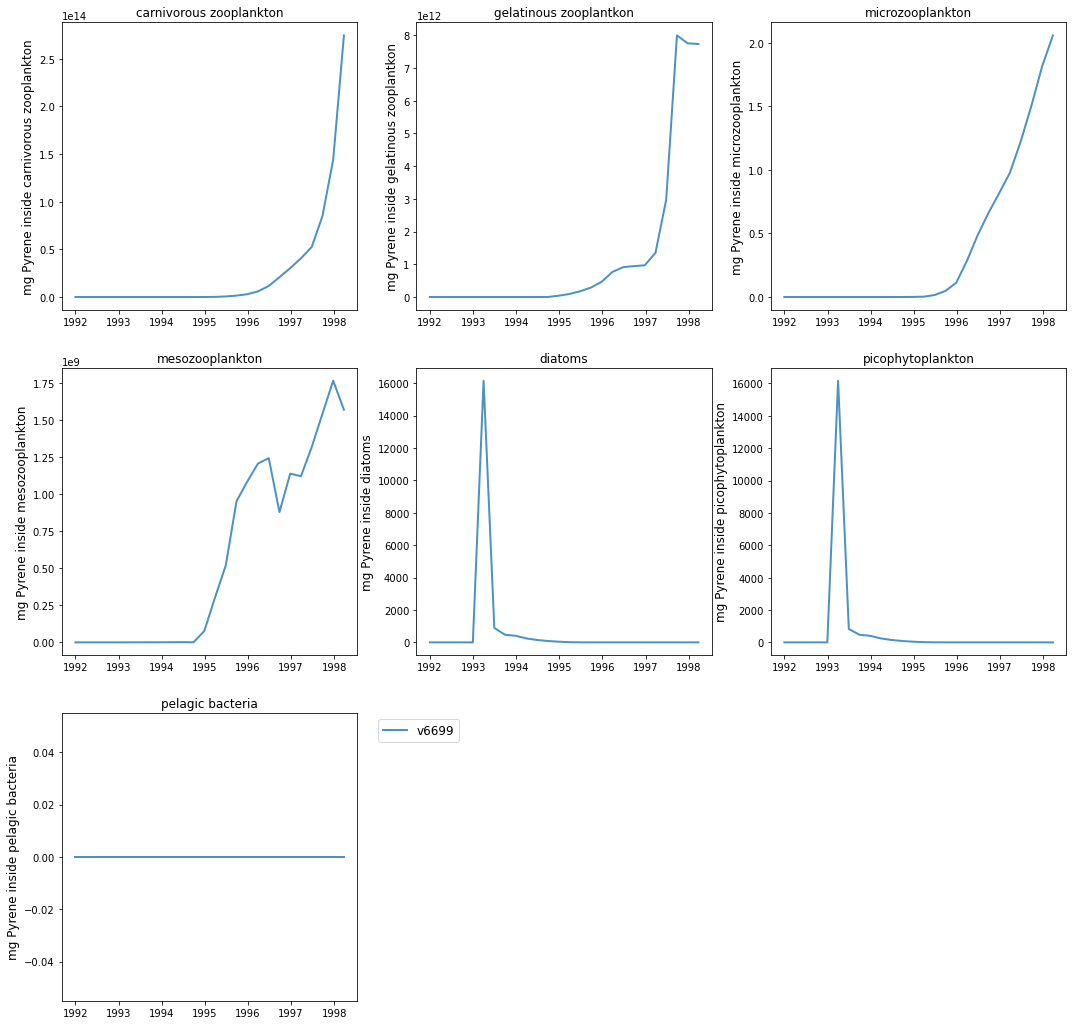

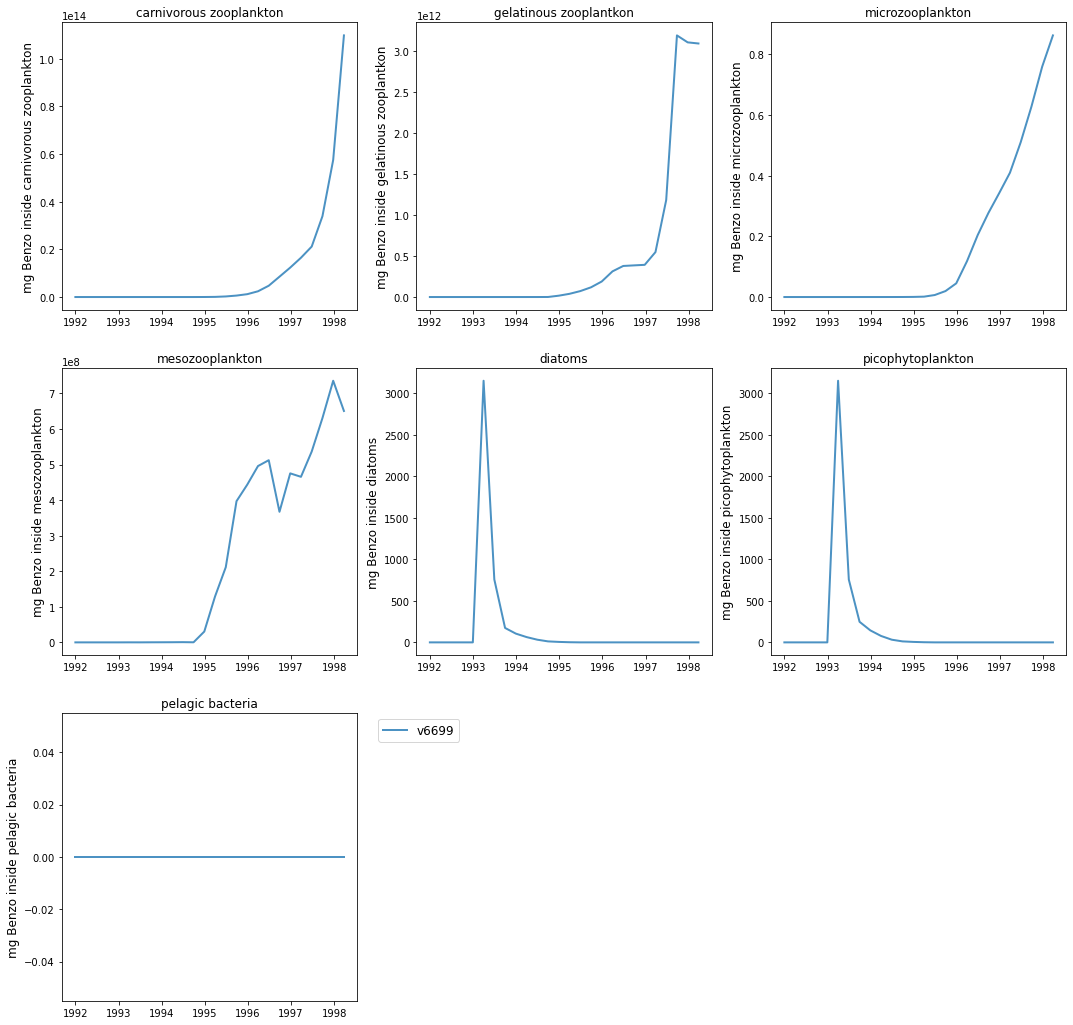

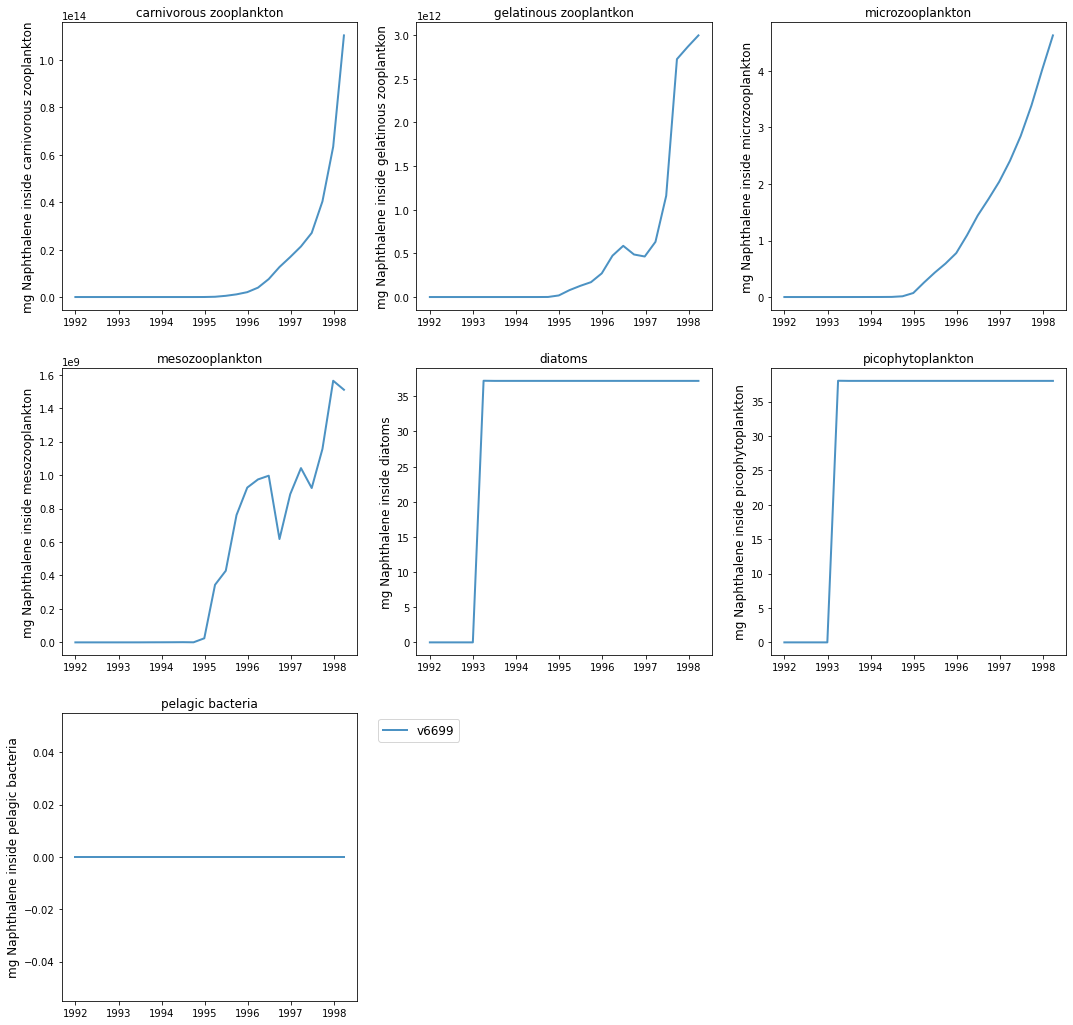

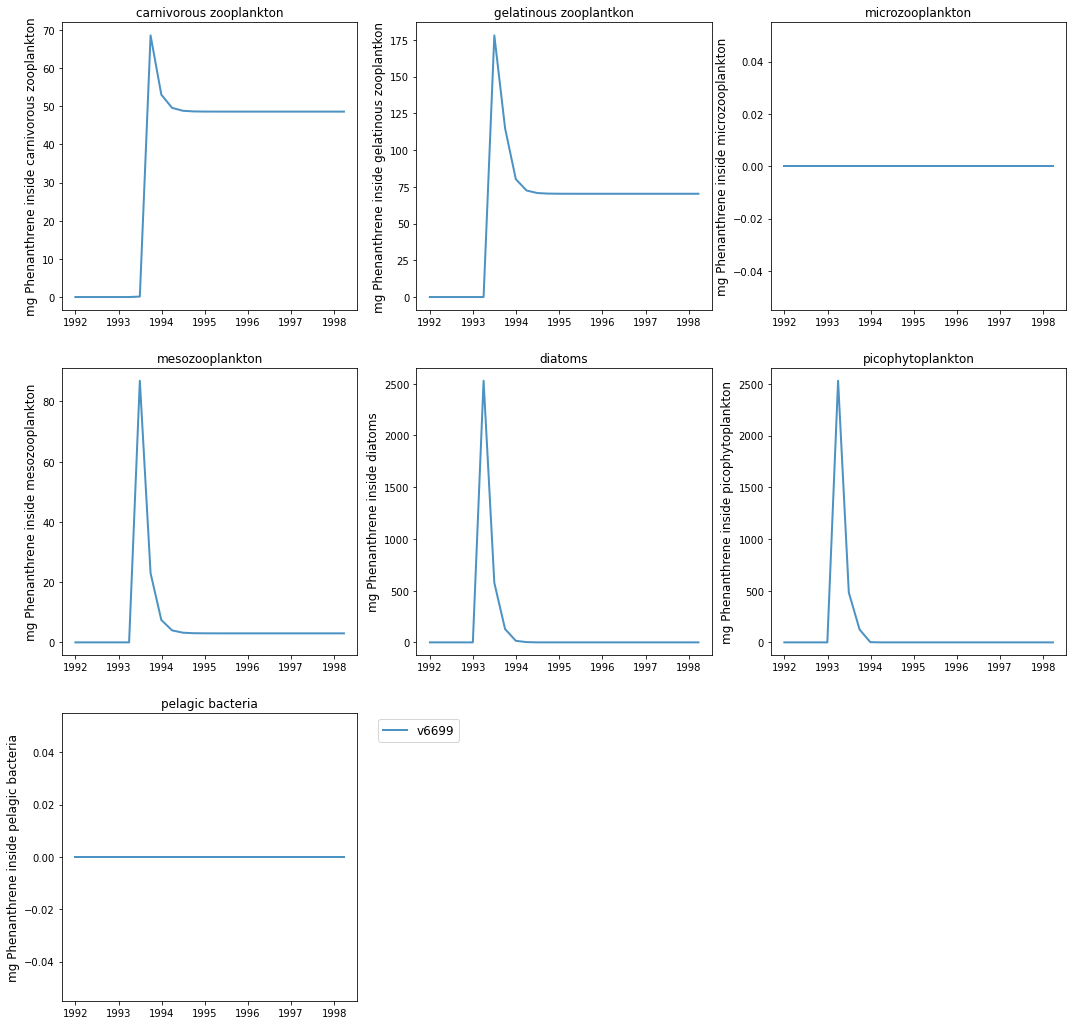

In [30]:
for pah in groups.pahs:
    tissue_mass(groups.plankton, pah, scen, names=label, time=time)

In [ ]:
for pah in groups.pahs:
    tissue_mass_log(groups.plankton, pah, scen, names=label, time=time)

In [ ]:
#Contaminants inside biology
end = time.size-1
for pah in groups.pahs:
    map_tissue_mass(groups.phytoplankton, pah, scen)

In [ ]:

for pah in groups.pahs:
    variable_name = 'Diatom_'+pah
    map_time_mass(variable_name, scenarios, end)

In [ ]:
variable_name = 'Diatom_Naphthalene'
for depth in range (0, 7):
    map_time_depth(variable_name, scenarios, 6, depth, names=labels, v_max=None, v_min=None)

In [ ]:
variable_name = 'Diatom_Naphthalene'
for depth in range (0, 7):
    map_time_depth(variable_name, scenarios, end, depth, names=labels, v_max=None, v_min=None)

### Invertebrates

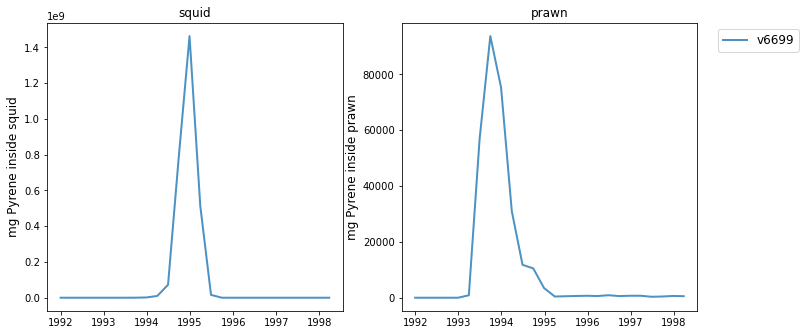

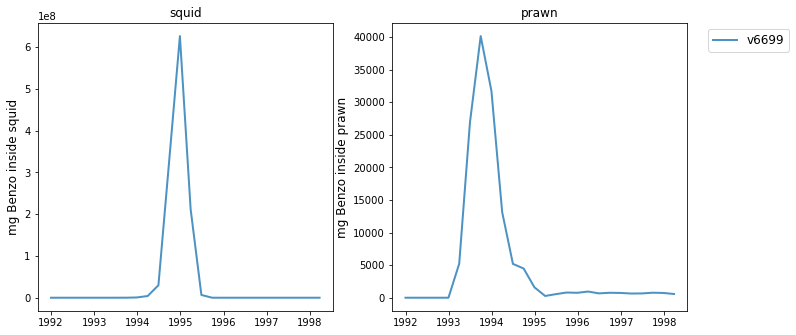

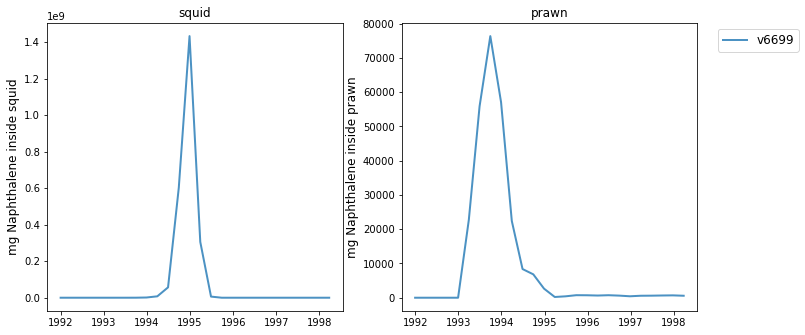

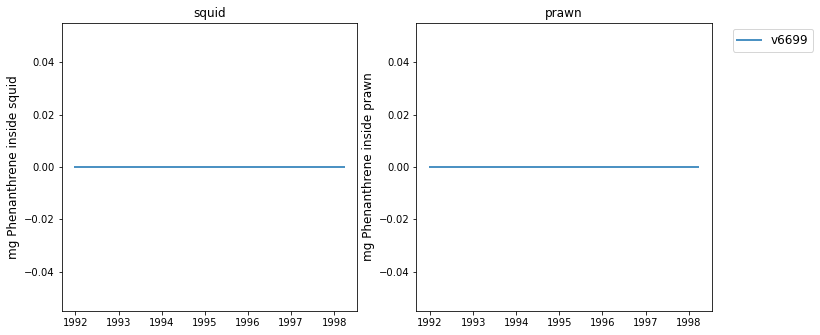

In [31]:
for pah in groups.pahs:
    tissue_mass(groups.pelagic_invertebrates, pah, scen, names=label)